In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.patches as patches


#parameters:
Ro = 1.
Re = 20.
dt = .0000625
nx = 251
ny = 251
nt = 20
nit = 50
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)



In [2]:
class obstacle(object):
    def __init__(self, x1, y1, x2, y2):
        self.botLeft = [x1, y1]
        self.topRight = [x2, y2]
        self.width = np.abs(x2-x1)
        self.height = np.abs(y2-y1)
    

In [18]:

def poissonSource(Ro, dt, dx, dy, u, v, periodic = False): ## this is (d_i u_j)(d_j u_i)
    S = np.empty_like(u)
    S[1:-1, 1:-1] = (Ro * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    if(periodic == True): ## periodic at x=0 and x = 2
        S[1:-1, -1] = (Ro * (1 / dt * ((u[1:-1, 0] - u[1:-1,-2]) / (2 * dx) +
                                    (v[2:, -1] - v[0:-2, -1]) / (2 * dy)) -
                          ((u[1:-1, 0] - u[1:-1, -2]) / (2 * dx))**2 -
                         2 * ((u[2:, -1] - u[0:-2, -1]) / (2 * dy) *
                               (v[1:-1, 0] - v[1:-1, -2]) / (2 * dx)) -
                          ((v[2:, -1] - v[0:-2, -1]) / (2 * dy))**2))

        S[1:-1, 0] = (Ro * (1 / dt * ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx) +
                                   (v[2:, 0] - v[0:-2, 0]) / (2 * dy)) -
                         ((u[1:-1, 1] - u[1:-1, -1]) / (2 * dx))**2 -
                        2 * ((u[2:, 0] - u[0:-2, 0]) / (2 * dy) *
                              (v[1:-1, 1] - v[1:-1, -1]) / (2 * dx))-
                         ((v[2:, 0] - v[0:-2, 0]) / (2 * dy))**2))

    return S

def pressurePoisson(p, dx, dy, S ,periodic = False):
    pn = np.empty_like(p) ## old P
    nit = 50
    for q in range(nit): ## nit iterations for 1 timestep!
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * S[1:-1, 1:-1])

        if(periodic == True):
            p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * S[1:-1, -1])

            p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * S[1:-1, 0])
    return p


def calculateFlow(conv, dt, dx, dy, Ro, Re, omega = 0., periodic = False, obstacle = False, wind = "left"): ## wind: driving on top, or left side
    error = 1
    timesteps = 0
    u = np.zeros((ny, nx))
    un = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    vn = np.zeros((ny, nx))
    p = np.ones((ny, nx))
    pn = np.ones((ny, nx))
    rho = (1./Re)*np.ones((ny, nx))
    g = 1.
    while error > conv: ##convergence condition
        un = u.copy()
        vn = v.copy()
        S = poissonSource(Ro, dt, dx, dy, u, v, periodic)
        p = pressurePoisson(p, dx, dy,S,  periodic) ## solve poisson equation (50 iterations)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / (2*dx) *  ##calculate step in U
                    (un[1:-1, 2:] - un[1:-1, 0:-2]) -
                     vn[1:-1, 1:-1] * dt / (2.*dy) * 
                    (un[1:-1, 1:-1] - un[2:, 0:-2]) -
                     dt / (2 * Ro* dx) * 
                    (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                     rho[1:-1, 1:-1] * (dt / dx**2 * 
                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) - 
                     2 * omega * vn[1:-1, 1:-1] * dt) + g*dt

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / (2*dx) *  ## calculate step in V
                    (vn[2:, 1:-1] - vn[0:-2, 1:-1]) -
                     vn[1:-1, 1:-1] * dt / (2*dy) * 
                    (vn[2:, 1:-1] - vn[0:-2, 1:-1]) -
                     dt / (2 * Ro * dy) * 
                    (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                     rho[1:-1, 1:-1] * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                     dt / dy**2 * 
                    (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])) +
                     2 * omega * un[1:-1, 1:-1] * dt ) 
        if(periodic == True):
            # for periodic boundary conditions, explicit definition of u[1:,-1, -1] is needed.
            
            u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / (2*dx) * 
                  (un[1:-1, 0] - un[1:-1, -2]) -
                   vn[1:-1, -1] * dt / (2*dy) * 
                  (un[1:-1, 0] - un[0:-2, -2]) -
                   dt / (2 * Ro * dx) *
                  (p[1:-1, 0] - p[1:-1, -2]) + 
                   rho[1:-1, -1] * (dt / dx**2 * 
                  (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                   dt / dy**2 * 
                  (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) - 
                   2 * omega * vn[1:-1, -1] * dt)
            u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (un[1:-1, 0] - un[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy * 
                 (un[1:-1, 0] - un[0:-2, 0]) - 
                  dt / (2 * Ro * dx) * 
                 (p[1:-1, 1] - p[1:-1, -1]) + 
                  rho[1:-1, 0] * (dt / dx**2 * 
                 (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                  dt / dy**2 *
                 (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) - 
                  2 * omega * vn[1:-1, 0] * dt)
            v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                  (vn[1:-1, -1] - vn[1:-1, -2]) - 
                   vn[1:-1, -1] * dt / dy *
                  (vn[1:-1, -1] - vn[0:-2, -1]) -
                   dt / (2 * Ro * dy) * 
                  (p[2:, -1] - p[0:-2, -1]) +
                   rho[1:-1,-1] * (dt / dx**2 *
                  (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                   dt / dy**2 *
                  (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])) +
                   2 * omega * un[1:-1, -1] * dt)

            v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                 (vn[1:-1, 0] - vn[1:-1, -1]) -
                  vn[1:-1, 0] * dt / dy *
                 (vn[1:-1, 0] - vn[0:-2, 0]) -
                  dt / (2 * Ro * dy) * 
                 (p[2:, 0] - p[0:-2, 0]) +
                  rho[1:-1, 0] * (dt / dx**2 * 
                 (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                  dt / dy**2 * 
                 (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])) + 
                 2 * omega * un[1:-1, 0] * dt)

        ##boundary conditioons:
        if(obstacle): ## 4 walls of the obstacle
            botLeftGrid = [int(obstacle.botLeft[0]/dx), int(obstacle.botLeft[1]/dy)]
            topRightGrid = [int(obstacle.topRight[0]/dx + 1), int(obstacle.topRight[1] / dy + 1)]
            
                           
            u[topRightGrid[1], botLeftGrid[0]: topRightGrid[0]]= 0 ## top
            u[botLeftGrid[1]:topRightGrid[1], botLeftGrid[0]] =0  ##left wall 
            u[botLeftGrid[1]:topRightGrid[1], topRightGrid[0]] =0 ## right wall
            u[botLeftGrid[1], botLeftGrid[0]: topRightGrid[1]]= 0 ## bot

            v[topRightGrid[1], botLeftGrid[0]: topRightGrid[0]]= 0 ## top
            v[botLeftGrid[1]:topRightGrid[1], botLeftGrid[0]] =0  ##left wall 
            v[botLeftGrid[1]:topRightGrid[1], topRightGrid[0]] =0 ## right wall
            v[botLeftGrid[1], botLeftGrid[0]: topRightGrid[1]]= 0 ## bot
        if(wind == "left"):
            u[:, 0] = 1.
            u[-1,:] = 0
        if(wind == "top"):
            u[-1, :] = 1. #set velocity to 1 on the top layer
            #u[:, 0] = 0.
            #u[:, -1]
        if(periodic == False):
            u[:,0] = 0
            u[:, -1] =0. #left and right walls
            v[:, 0] = 0
            v[:, -1] = 0
        ##bottom wall:
        u[0, :] = 0.
        v[0, :]=0
        ##top wall vertical comp:
        v[-1, :] = 0

        error = (np.sum(u) - np.sum(un)) / np.sum(u)
        timesteps += 1 ## L1 norm

    print("Convergence took " + str(timesteps) + " steps.")
    return u, v, p

## Infinite tube with Coriolis force and obstacle

In [ ]:
#initial conds.
omega = 0.
dt = .0000525
nx = 301
ny = 301
dx = 2. / (nx - 1.)
dy = 2. / (ny - 1.)
x = np.linspace(0, 2., nx)
y = np.linspace(0, 2., ny)
X, Y = np.meshgrid(x, y)
brick = obstacle(0.5, 0., 1.0, 0.5)
u,v, p = calculateFlow(1e-5, dt, dx, dy, Ro, Re, 0., True, False, "left")
u2,v2, p2 = calculateFlow(1e-5, dt, dx, dy, Ro, Re, 0., True, brick, "left")


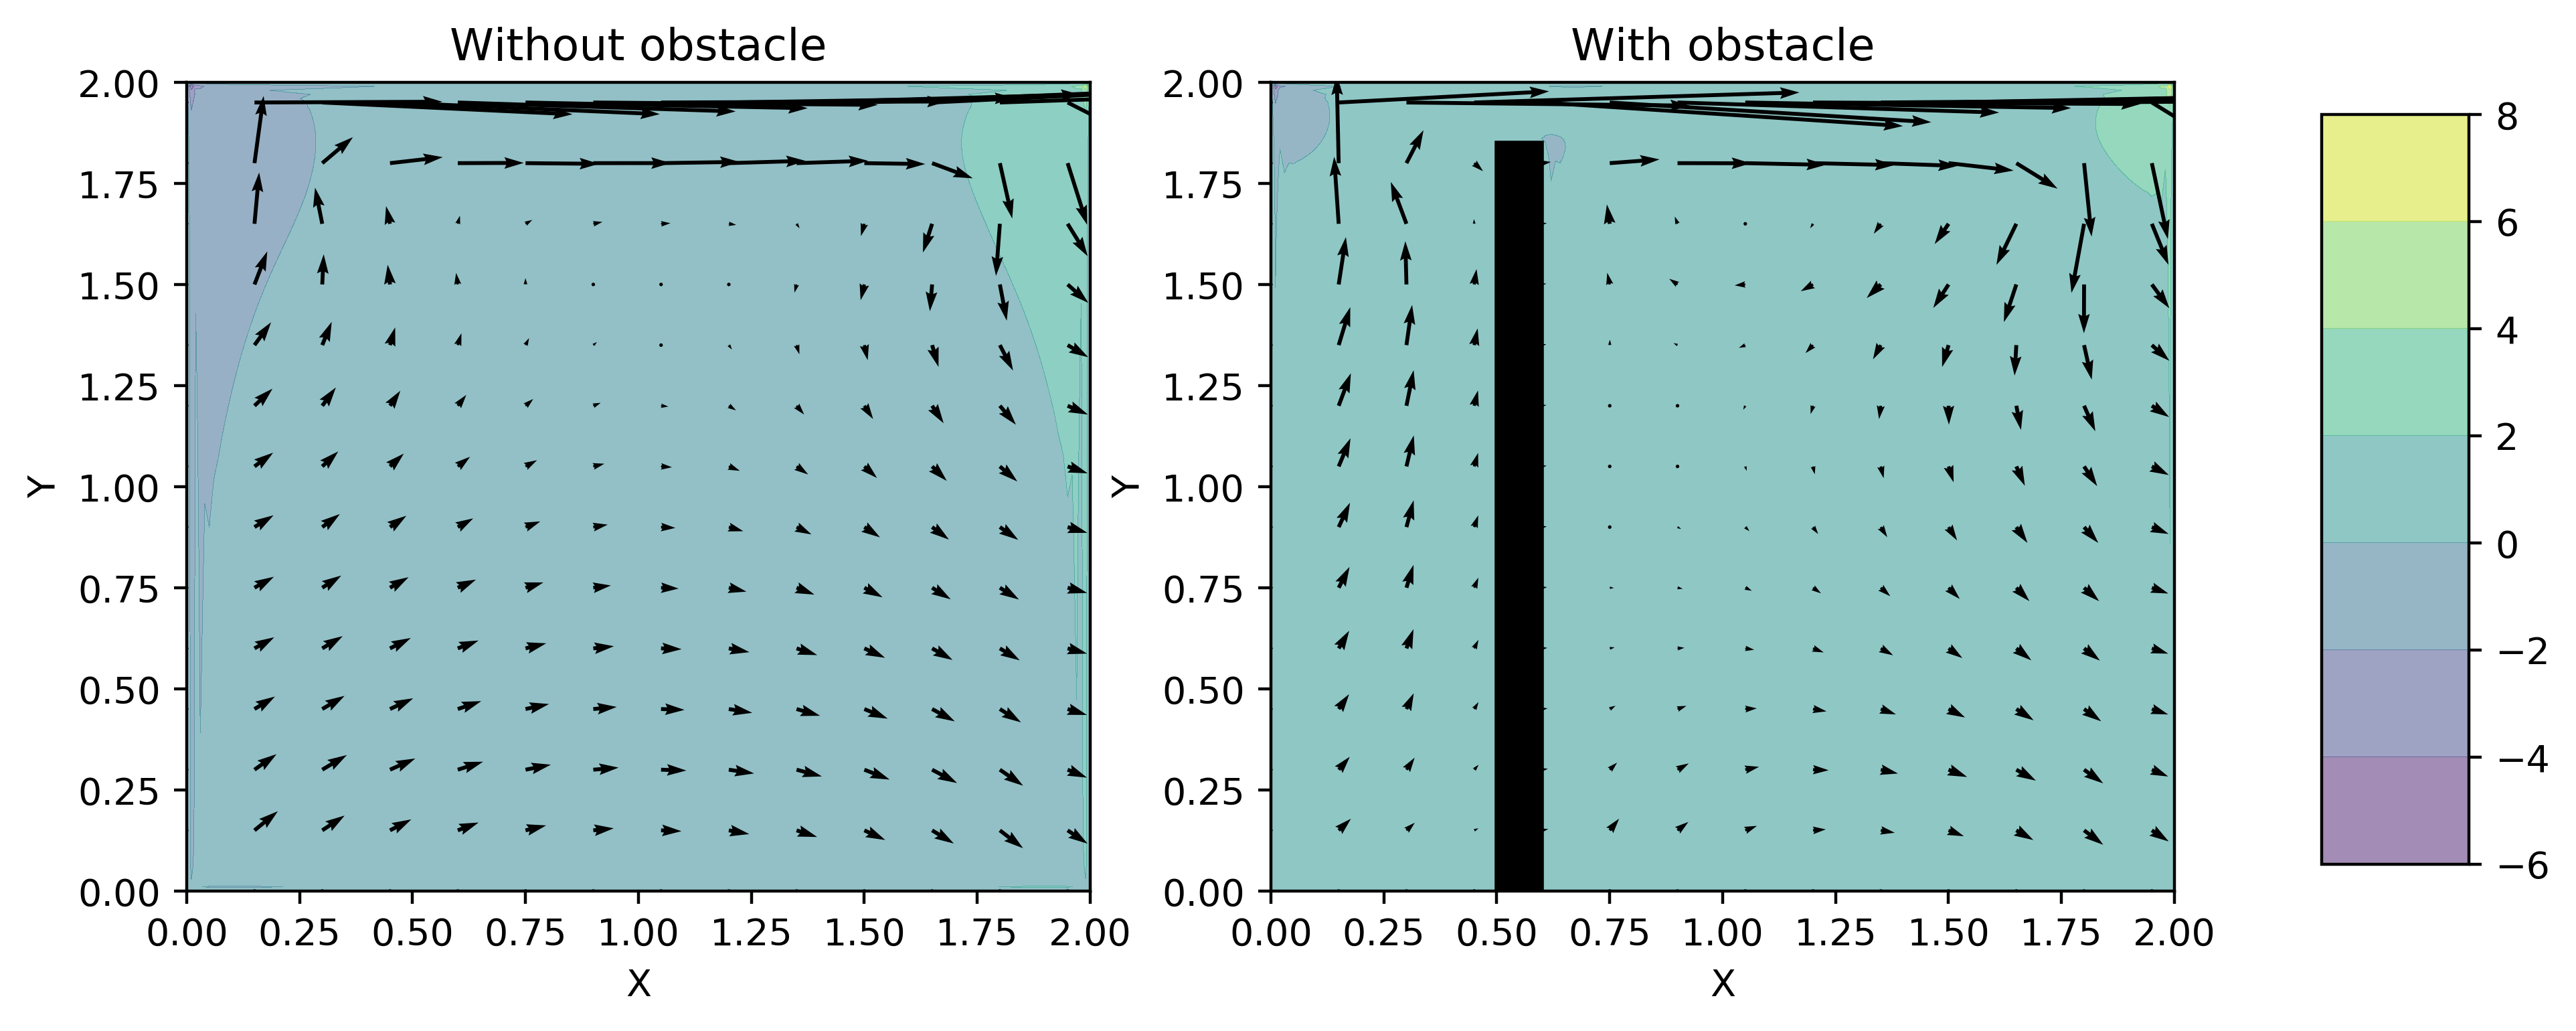

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(11,4), dpi =400 )
ax1, ax2 = axes
ax1.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
im = ax1.quiver(X[::15, ::15], Y[::15, ::15], u[::15, ::15], v[::15, ::15])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title("Without obstacle")

im=ax2.contourf(X, Y, p2, alpha=0.5, cmap=cm.viridis)  
ax2.quiver(X[::15, ::15], Y[::15, ::15], u2[::15, ::15], v2[::15, ::15])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title("With obstacle")
ax2.add_patch( patches.Rectangle(brick.botLeft, brick.width, brick.height, color = 'black'))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('fig1.pdf', bbox_inches='tight')

In [19]:
#initial conds.
omega = 0.
dt = .000125
nx = 201
ny = 201
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)
brick = obstacle(0.5, 0., 0.6, 1.85)
u,v, p = calculateFlow(1e-5, dt, dx, dy, Ro, Re, 0., False, False, "top")
u2,v2, p2 = calculateFlow(1e-5, dt, dx, dy, Ro, Re, 0., False, brick, "top")


Convergence took 2089 steps.
Convergence took 2262 steps.


[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.02054715  0.01362496 ...,  0.01917419  0.02893679  0.        ]
 [ 0.          0.02453157  0.01784989 ...,  0.02501252  0.03444955  0.        ]
 ..., 
 [ 0.          0.32048248  0.31100554 ...,  0.33363555  0.35104968  0.        ]
 [ 0.          0.54071247  0.53305972 ...,  0.55458802  0.57442268  0.        ]
 [ 0.          1.          1.         ...,  1.          1.          0.        ]]
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.02014892  0.02326635 ..., -0.03316392 -0.02853341  0.        ]
 [ 0.          0.01352     0.01707634 ..., -0.02427685 -0.01911718  0.        ]
 ..., 
 [ 0.          0.06974071  0.05265647 ..., -0.04509938 -0.06508164  0.        ]
 [ 0.         -0.11138093 -0.08871063 ...,  0.10185955  0.12482316  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


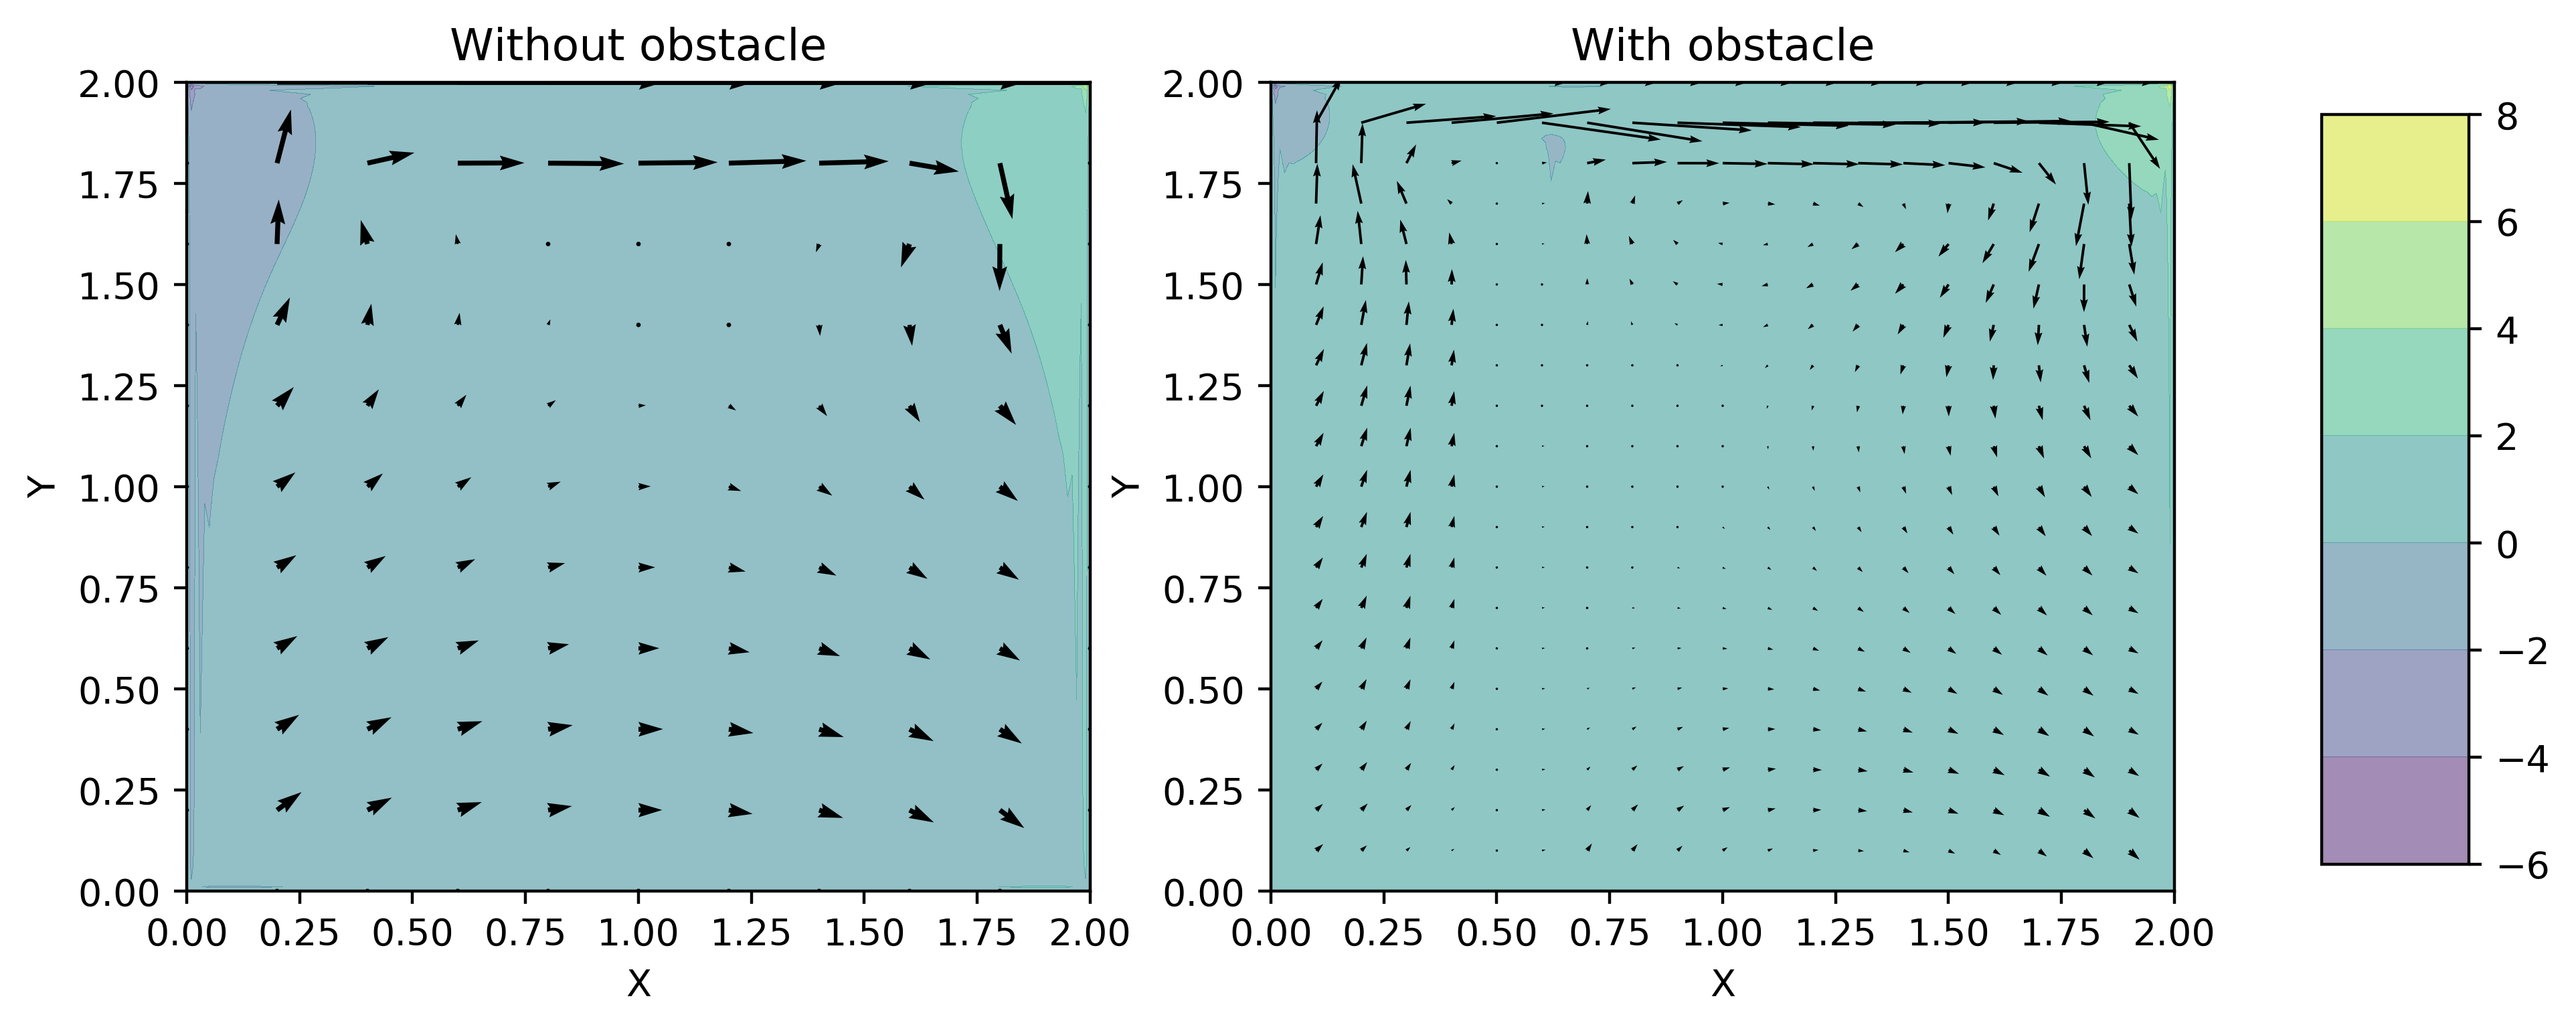

In [20]:
print(u2)
print(v2)
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(11,4), dpi =400 )
ax1, ax2 = axes
ax1.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
im = ax1.quiver(X[::20, ::20], Y[::20, ::20], u[::20, ::20], v[::20, ::20])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title("Without obstacle")

im=ax2.contourf(X, Y, p2, alpha=0.5, cmap=cm.viridis)  
ax2.quiver(X[::10, ::10], Y[::10, ::10], u2[::10, ::10], v2[::10, ::10])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title("With obstacle")
#ax2.add_patch( patches.Rectangle(brick.botLeft, brick.width, brick.height, color = 'black'))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('fig2.pdf', bbox_inches='tight')

## Flow in the presence of Coriolis force

In [130]:
#initial conds.
dt = .0000325
nx = 301
ny = 301
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)
brick = obstacle(0.5, 0.5, 1.0, 1.0)
u2,v2, p2 = calculateFlow(1e-6, dt, dx, dy, Ro, Re, -20., True, brick, "left")
u,v, p = calculateFlow(1e-6, dt, dx, dy, Ro, Re, -20., True, False, "left")


Convergence took 1488 steps.
Convergence took 1268 steps.


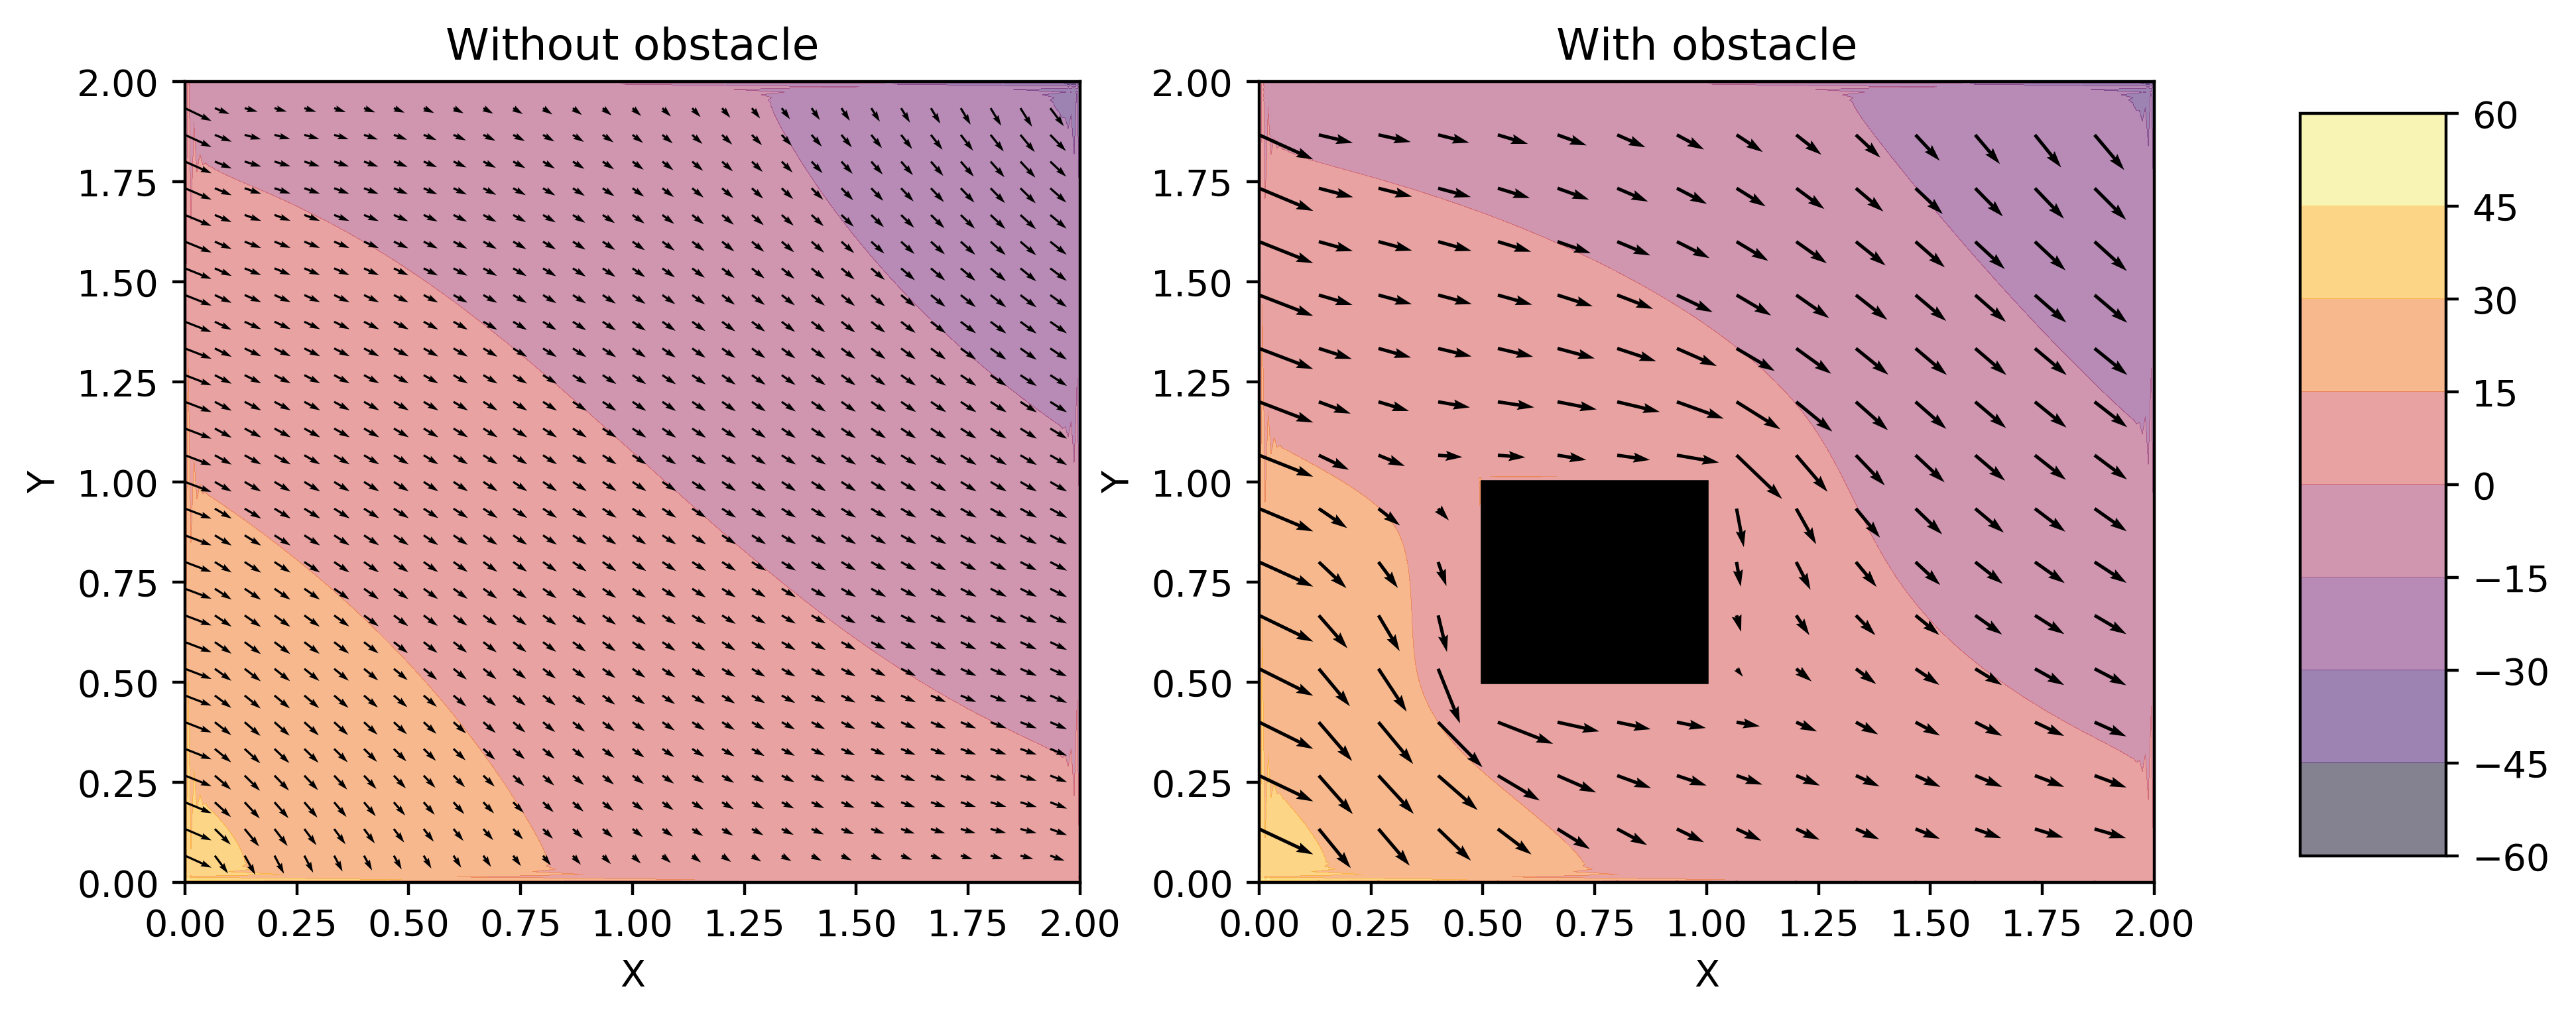

In [137]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(11,4), dpi =400 )
ax1, ax2 = axes
ax1.contourf(X, Y, p, alpha=0.5, cmap=cm.inferno)  
im = ax1.quiver(X[::20, ::20], Y[::20, ::20], u[::20, ::20], v[::20, ::20])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title("Without obstacle")

im=ax2.contourf(X, Y, p2, alpha=0.5, cmap=cm.inferno)  
ax2.quiver(X[::20, ::20], Y[::20, ::20], u2[::20, ::20], v2[::20, ::20])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title("With obstacle")
ax2.add_patch( patches.Rectangle(brick.botLeft, brick.width, brick.height, color = 'black'))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('fig3.pdf', bbox_inches='tight')

In [60]:
dt = .00000125
nx = 401
ny = 401
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)
brick = obstacle(0.75, 0.75, 0.5, 0.5)
#u2,v2, p2 = calculateFlow(1e-5, dt, dx, dy, Ro, Re, -600.,True, False, "left")
u,v, p = calculateFlow(1e-5, dt, dx, dy, Ro, Re, -0.1, True, False, "left")


Convergence took 16391 steps.


(401,)
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-0.10867714 -0.22273219 -0.1796762  ...,  0.0444052  -0.01972464
   0.04644811]
 [-0.0202603  -0.01413919 -0.03678612 ...,  0.00845783  0.0004716
  -0.01239148]
 ..., 
 [-0.02077208 -0.0125678   0.00042305 ..., -0.03576749 -0.03676367
  -0.01451453]
 [-0.10962673  0.04613916 -0.01976186 ..., -0.21704526 -0.17974088
  -0.22385703]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


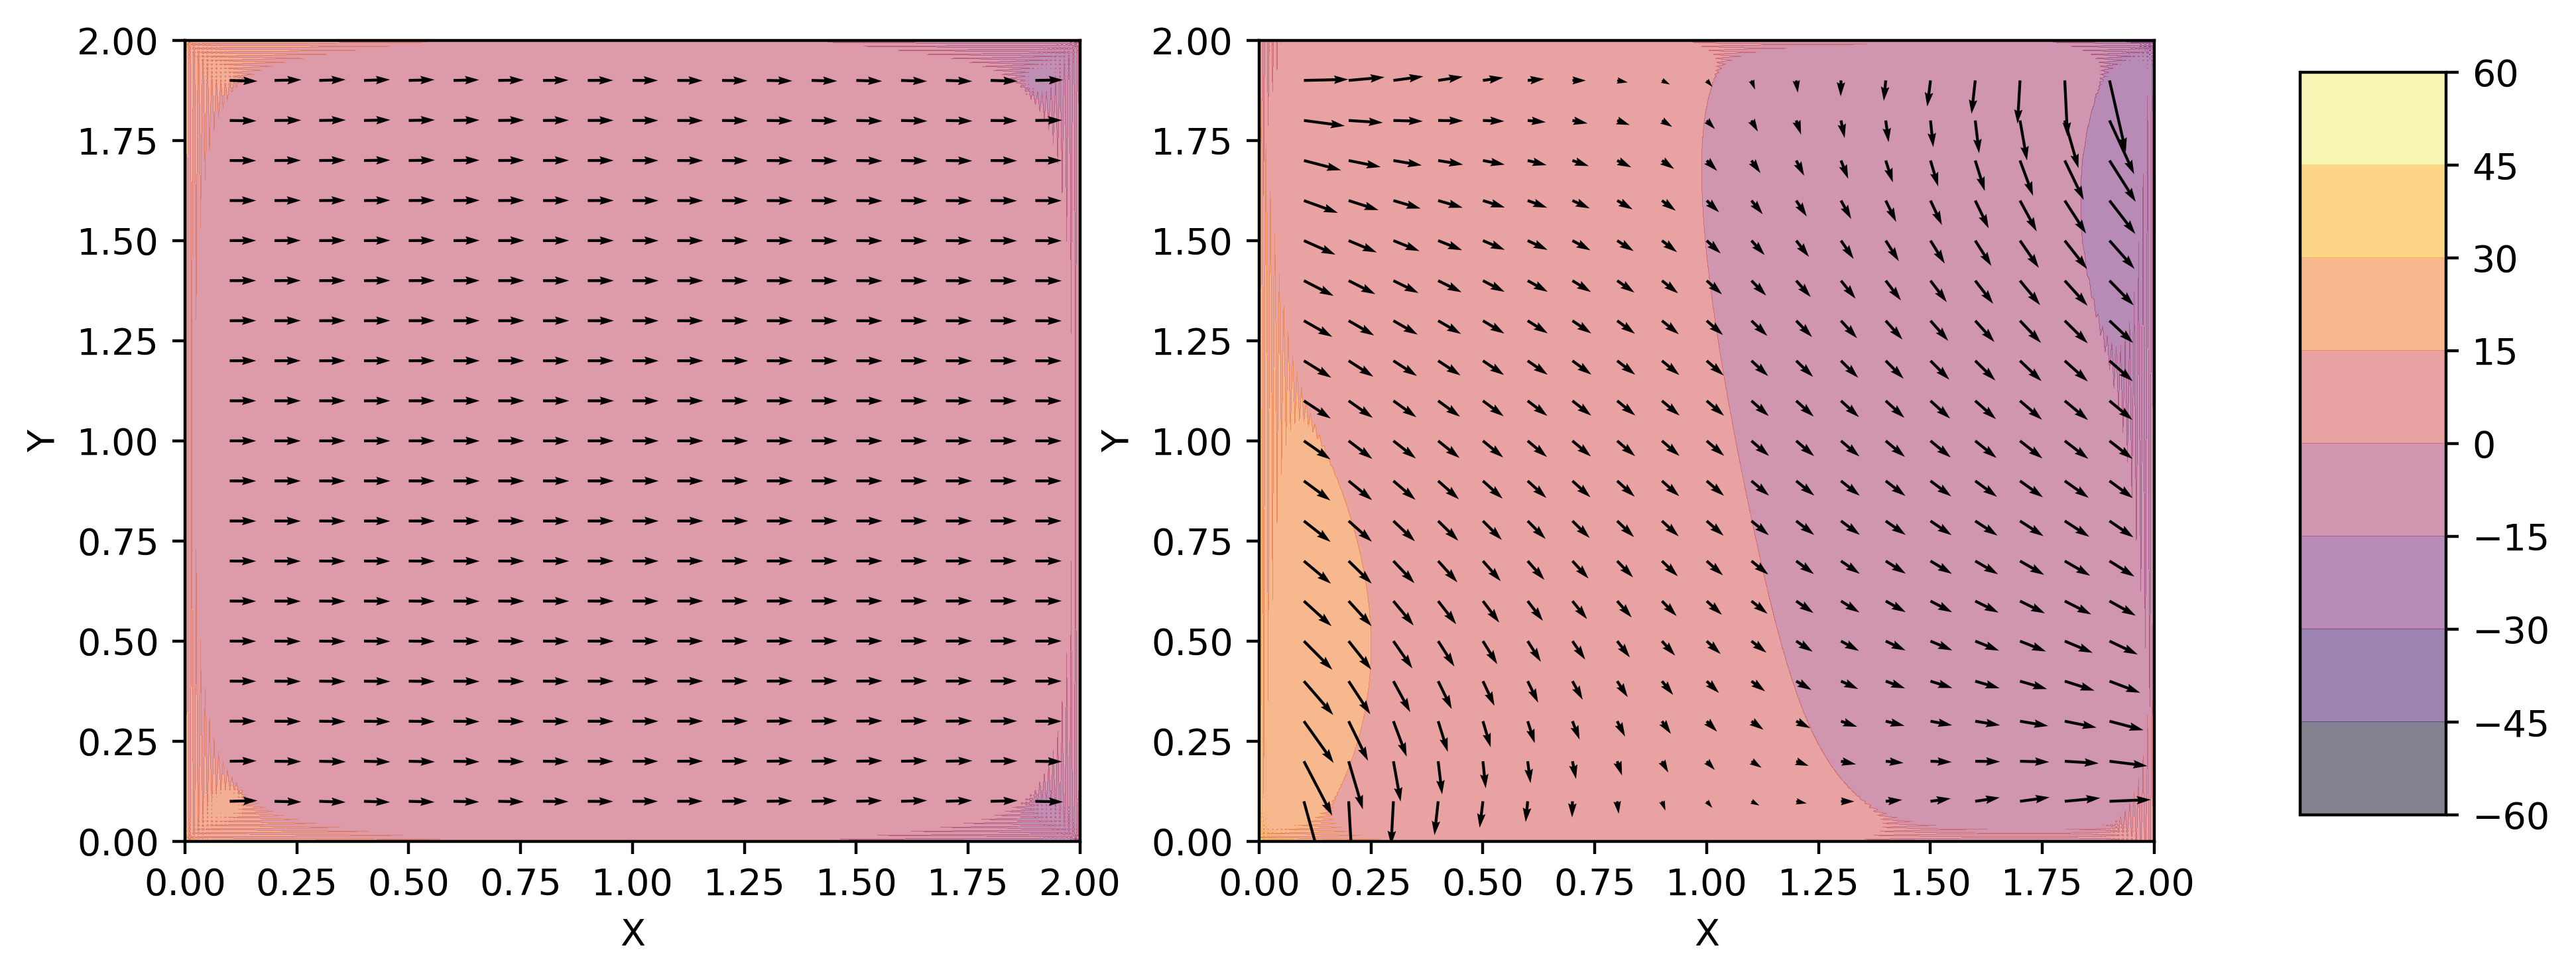

In [61]:
print(x.shape)
print(v2)
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(11,4), dpi =400 )
ax1, ax2 = axes
ax1.contourf(X, Y, p, alpha=0.5, cmap=cm.inferno)  
im = ax1.quiver(X[20:-20, 20:-20][::20, ::20], Y[20:-20, 20:-20][::20, ::20], u[20:-20,20:-20][::20, ::20], v[20:-20, 20:-20][::20, ::20])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
#ax1.set_title("Without obstacle")

im=ax2.contourf(X, Y, p2, alpha=0.5, cmap=cm.inferno)  
ax2.quiver(X[20:-20, 20:-20][::20, ::20], Y[20:-20, 20:-20][::20, ::20], u2[20:-20,20:-20][::20, ::20], v2[20:-20, 20:-20][::20, ::20])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
#ax2.set_title("With obstacle")
#ax2.add_patch( patches.Rectangle(brick.botLeft, brick.width, brick.height, color = 'black'))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('fig5.pdf', bbox_inches='tight')